# Tutorial

> The goal of this challenge is to find all instances of dolphins in a picture and then color pixes of each dolphin with a unique color.

Please open this notebook in Colab to edit it and submit a solution:
    
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cro-ai-league/dolphins-recognition-challenge/blob/master/notebooks/00_Tutorial.ipynb)

In [ ]:
try:
    import dolphins_recognition_challenge
except Exception:
    if "google.colab" in str(get_ipython()):
        print("Running on CoLab")
        !pip install dolphins-recognition-challenge

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import PIL
from PIL import Image

import torch
import torchvision
import pandas as pd
import seaborn as sns

## Download data

We start by downloading and visualizing the dataset containing 200 photographs with one or more dolphins split into a training set containing 160 photographs and a validation set containing 40 photographs.

In [ ]:
from dolphins_recognition_challenge.datasets import get_dataset, display_batches
    
data_loader, data_loader_test = get_dataset("segmentation", batch_size=3)

display_batches(data_loader, n_batches=2)

## Data augmentation

In order to prevent overfitting which happens when the dataset size is too small, we perform a number of transformations to increase the size of the dataset. One transofrmation implemented in the Torch vision library is `RandomHorizontalFlip` and we will implemented `MyColorJitter` which is basically just a wrapper around `torchvision.transforms.ColorJitter` class. However, we cannot use this class directly without a wrapper because a transofrmation could possibly affect targets and not just the image. For example, if we were to implement RandomCrop, we would need to crop segmentation masks and readjust bounding boxes as well.

In [ ]:
class MyColorJitter:
    def __init__(self, brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5):
        self.torch_color_jitter = torchvision.transforms.ColorJitter(
            brightness=brightness, contrast=contrast, saturation=saturation, hue=hue
        )

    def __call__(self, image, target):
        image = self.torch_color_jitter(image)
        return image, target

We will make a series of transformations on an image and we will combine all those transofrmations in a single one as follows:

In [ ]:
from dolphins_recognition_challenge.datasets import ToTensor, ToPILImage, Compose, RandomHorizontalFlip

def get_tensor_transforms(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(
            MyColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
        )
        transforms.append(RandomHorizontalFlip(0.5))
        # TODO: add additional transforms: e.g. random crop
    return Compose(transforms)

With data augementation defined, we are ready to generate the actual datasets used for training our models.

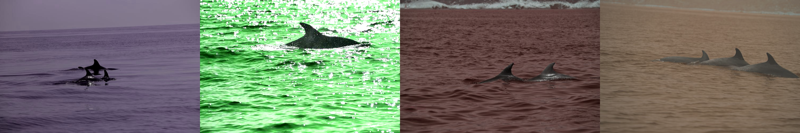

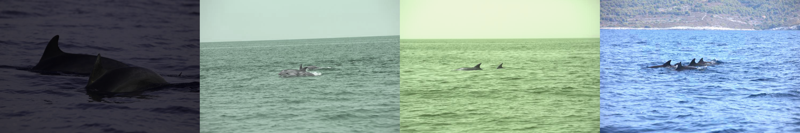

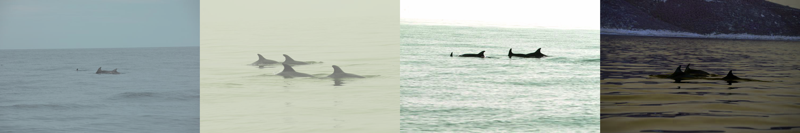

In [ ]:
batch_size = 4

data_loader, data_loader_test = get_dataset(
    "segmentation", get_tensor_transforms=get_tensor_transforms, batch_size=batch_size
)

display_batches(data_loader, n_batches=4)

> Tip: incorporate more transformation classes such as RandomCrop etc. (https://pytorch.org/docs/stable/torchvision/transforms.html)

## Model

We can reuse already trained models for instance segmentation trained on other dataset and finetune it for our particular problem, in our case on dataset with dolphins.

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_instance_segmentation_model(hidden_layer_size, box_score_thresh=0.5):
    # our dataset has two classes only - background and dolphin    
    num_classes = 2
    
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        pretrained=True, 
        box_score_thresh=box_score_thresh, 
    )

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_channels=in_features_mask, 
        dim_reduced=hidden_layer_size,
        num_classes=num_classes
    )

    return model

Before using a model constructed, we should move it to appropriate device. We will test if we have GPU available and move it to there if possible.

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# get the model using our helper function
model = get_instance_segmentation_model(hidden_layer_size=256)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

We have implemented a function for training a model for one epoch - meaning using each image from the training dataset exactly once. Let's train for one epochs an see what predictions we make before and after that.

In [ ]:
# hide

# used for automatic testing only
data_loader, data_loader_test = get_dataset(
    "segmentation",
    batch_size=4,
    get_tensor_transforms=get_tensor_transforms,
    n_samples=8,
)

In [ ]:


data_loader, data_loader_test = get_dataset(
    "segmentation", get_tensor_transforms=get_tensor_transforms, batch_size=batch_size
)

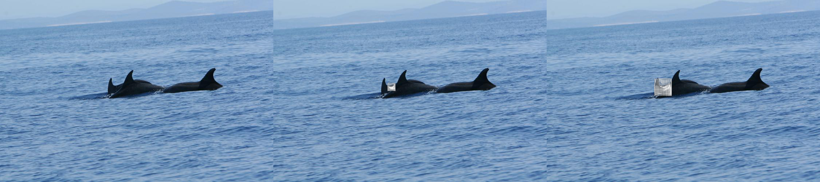

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [ 0/40]  eta: 0:01:32  lr: 0.000133  loss: 2.7910 (2.7910)  loss_classifier: 0.3689 (0.3689)  loss_box_reg: 0.3244 (0.3244)  loss_mask: 2.0256 (2.0256)  loss_objectness: 0.0455 (0.0455)  loss_rpn_box_reg: 0.0266 (0.0266)  time: 2.3011  data: 1.4662  max mem: 4480
Epoch: [0]  [20/40]  eta: 0:00:15  lr: 0.002695  loss: 0.9099 (1.2793)  loss_classifier: 0.1952 (0.2234)  loss_box_reg: 0.2720 (0.2795)  loss_mask: 0.3387 (0.7139)  loss_objectness: 0.0168 (0.0329)  loss_rpn_box_reg: 0.0142 (0.0298)  time: 0.7005  data: 0.0123  max mem: 5184
Epoch: [0]  [39/40]  eta: 0:00:00  lr: 0.005000  loss: 0.6380 (0.9913)  loss_classifier: 0.1036 (0.1672)  loss_box_reg: 0.2225 (0.2570)  loss_mask: 0.2493 (0.5012)  loss_objectness: 0.0109 (0.0279)  loss_rpn_box_reg: 0.0154 (0.0381)  time: 0.6736  data: 0.0129  max mem: 5184
Epoch: [0] Total time: 0:00:29 (0.7300 s / it)
Epoch: [1]  [ 0/40]  eta: 0:01:01  lr: 0.005000  loss: 0.6572 (0.6572)  loss_classifier: 0.0904 (0.0904)  loss_box_reg: 0.222

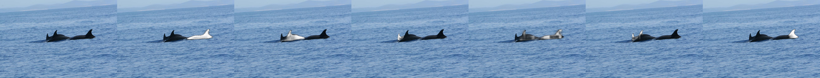

In [ ]:
from dolphins_recognition_challenge.instance_segmentation.model import train_one_epoch
from dolphins_recognition_challenge.instance_segmentation.model import show_predictions

show_predictions(model, data_loader=data_loader_test, n=1, score_threshold=0.5)

num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch=epoch, print_freq=20)

train_one_epoch(model, optimizer, data_loader, device, epoch=1, print_freq=20)

show_predictions(model, data_loader=data_loader_test, n=1, score_threshold=0.5)

Now we can fully train the model for more epochs, in this case for 20 more.

In [ ]:
# slow

num_epochs = 20

data_loader, data_loader_test = get_dataset(
    "segmentation", batch_size=4, get_tensor_transforms=get_tensor_transforms
)

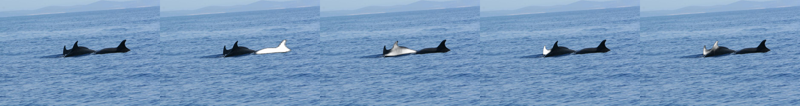

In [ ]:
for epoch in range(1, num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch=epoch, print_freq=20)

    lr_scheduler.step()

## Calculate metrics

Visualise few samples and print the IOU metric for those samples 

IOU metric for the input image is: 0.6259810766972614


IOU metric for the input image is: 0.6460097950115702


IOU metric for the input image is: 0.6091511015739368


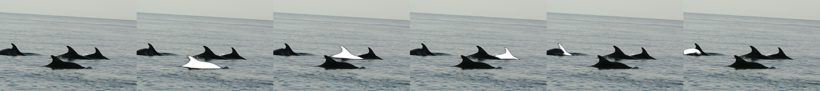

IOU metric for the input image is: 0.5190530680012663


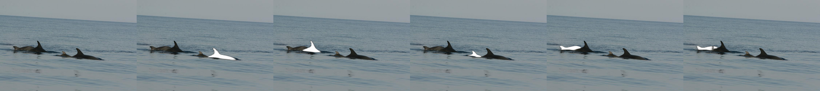

In [ ]:
from dolphins_recognition_challenge.instance_segmentation.model import show_prediction, iou_metric_example

for i in range(4):
    iou_test_image = iou_metric_example(model, data_loader_test.dataset[i], 0.5)
    img, _ = data_loader_test.dataset[i]
    print(f"IOU metric for the input image is: {iou_test_image}")
    show_prediction(model, img, width=820)


Calculate the mean IOU metric for the entire data set

In [ ]:
%%time

from dolphins_recognition_challenge.instance_segmentation.model import iou_metric, show_predictions_sorted_by_iou

mean_iou_testset, _ = iou_metric(model, data_loader_test.dataset)

print(f"Mean IOU metric for the test set is: {mean_iou_testset}")

Mean IOU metric for the test set is: 0.46612733142231566
CPU times: user 11.9 s, sys: 140 ms, total: 12.1 s
Wall time: 7.68 s


...

IOU metric: 0.22502997305030265


IOU metric: 0.2310022767064216


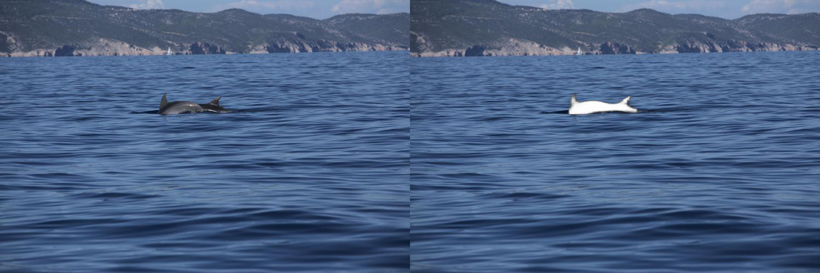

IOU metric: 0.25734664240174077


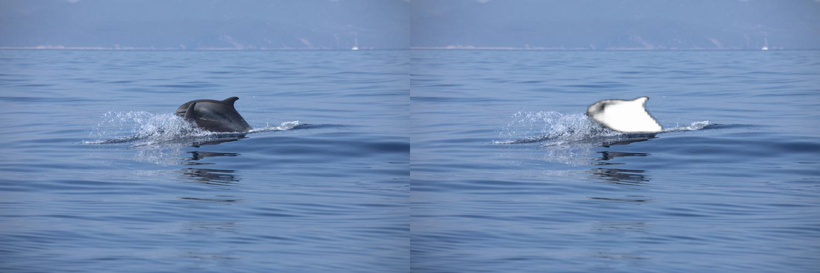

IOU metric: 0.26085251727299363


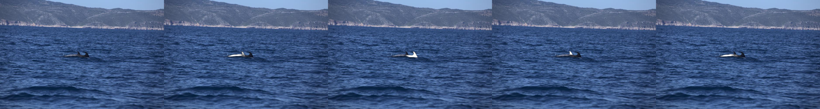

IOU metric: 0.30655694693737234


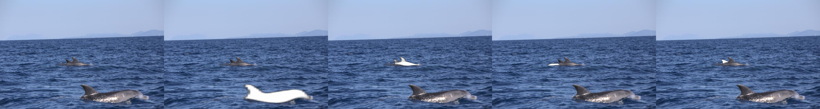

IOU metric: 0.31508163184622695


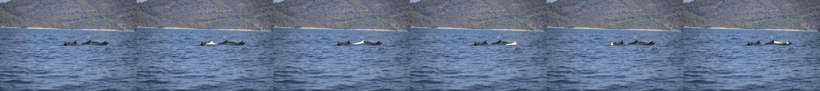

IOU metric: 0.3218397135252717


IOU metric: 0.3456766023528036


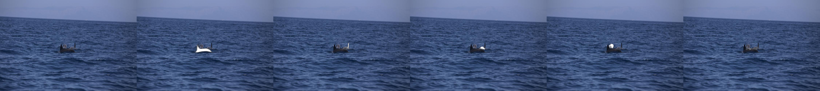

IOU metric: 0.3470369648614928


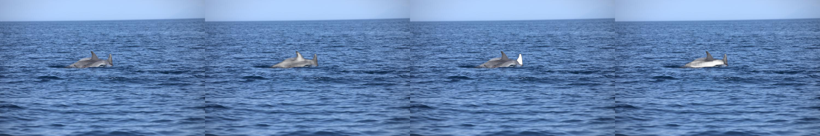

IOU metric: 0.3546700235484362


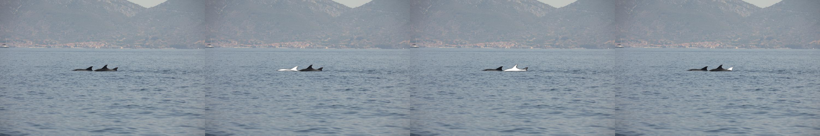

IOU metric: 0.3609142976018186


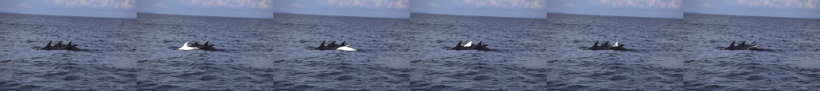

IOU metric: 0.37284602970490716


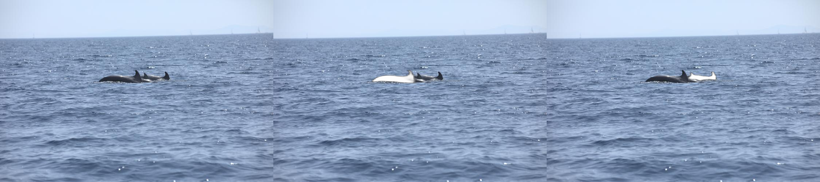

IOU metric: 0.38463323148250456


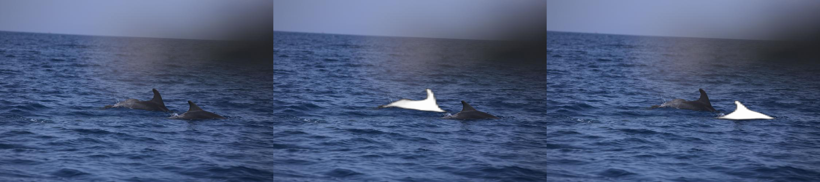

IOU metric: 0.4066482300308487


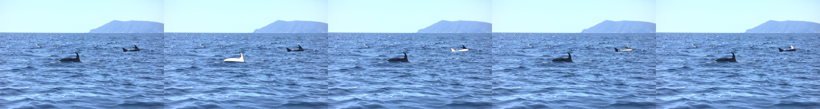

IOU metric: 0.4079725575943764


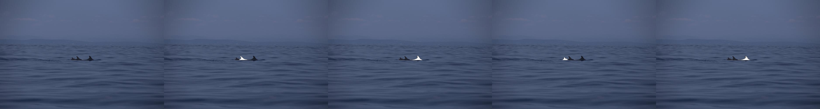

IOU metric: 0.4081568239475916


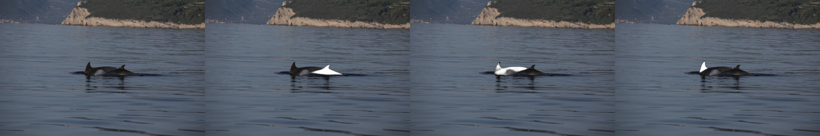

IOU metric: 0.42753368078480436


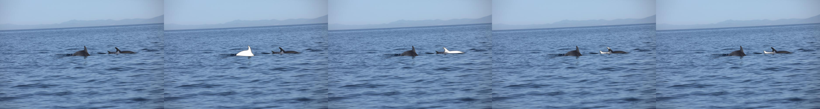

IOU metric: 0.4278336119441357


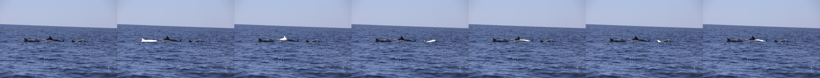

IOU metric: 0.4297013912573859


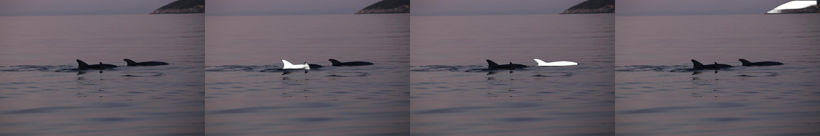

IOU metric: 0.44626256872053416


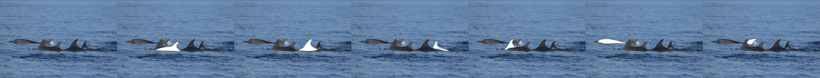

IOU metric: 0.4546928926888515


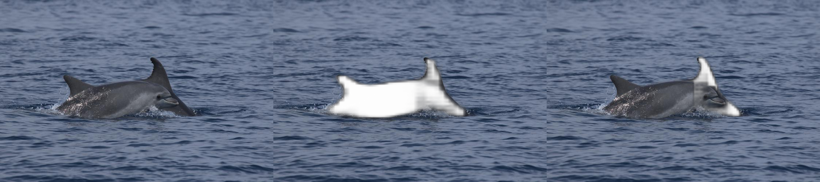

IOU metric: 0.45805453446776007


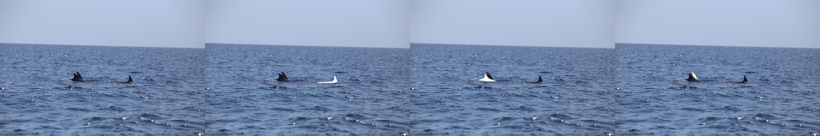

IOU metric: 0.4660661166600095


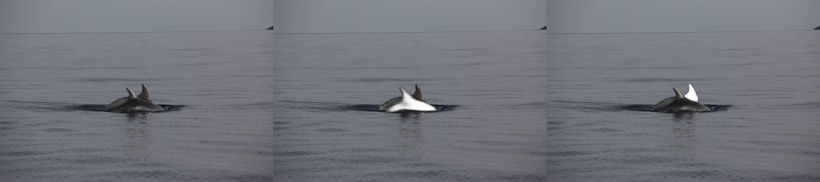

IOU metric: 0.47087873850755024


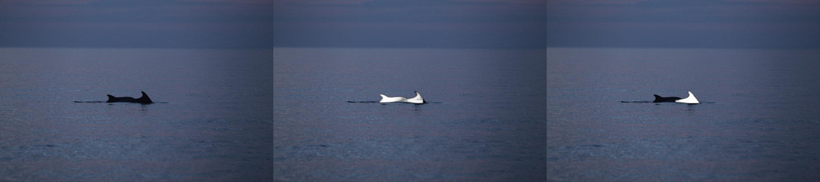

IOU metric: 0.5190530680012663


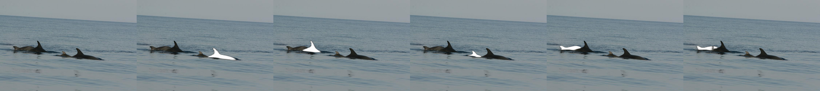

IOU metric: 0.532799544739304


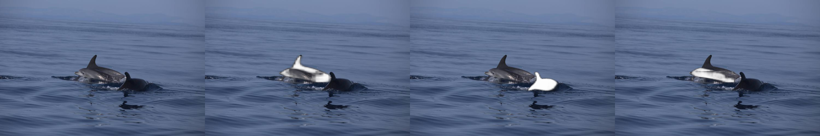

IOU metric: 0.538217734202439


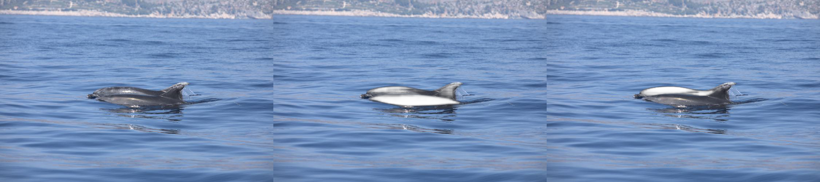

IOU metric: 0.571153696411214


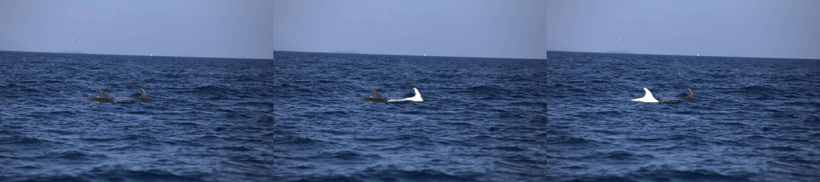

IOU metric: 0.5973374817409152


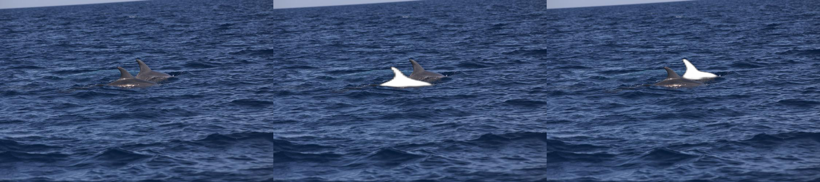

IOU metric: 0.6091511015739368


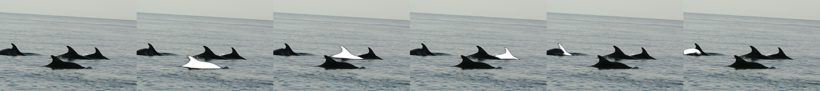

IOU metric: 0.6223583542398201


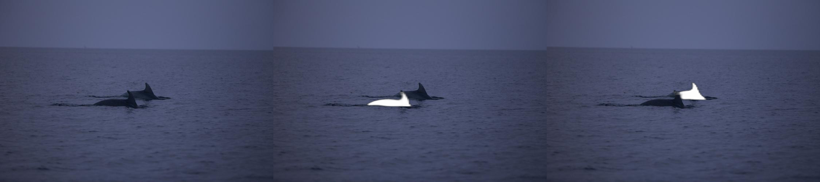

IOU metric: 0.6259810766972614


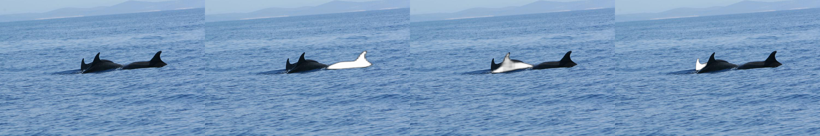

IOU metric: 0.6280768801584529


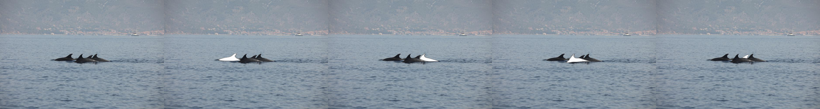

IOU metric: 0.6370386960413631


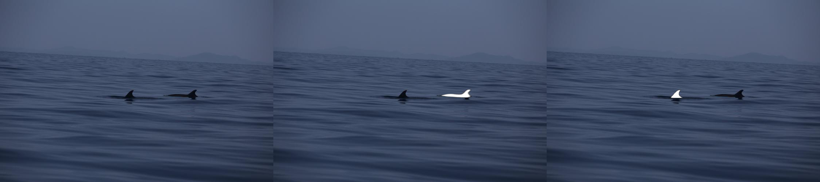

IOU metric: 0.6460097950115702


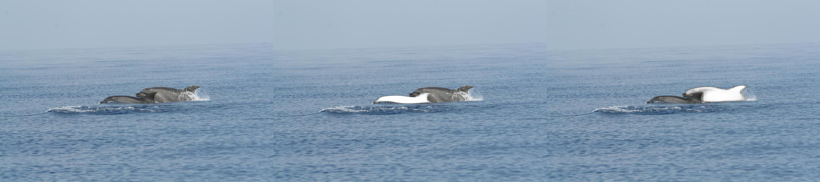

IOU metric: 0.6503663656274578


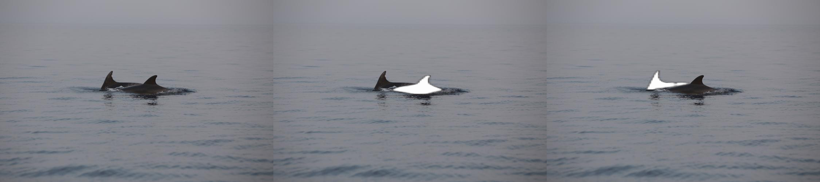

IOU metric: 0.6677207893103368


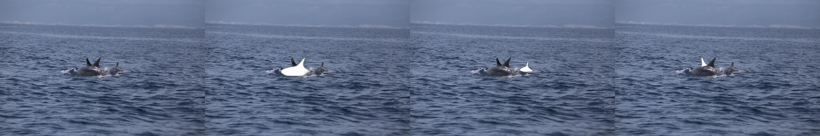

IOU metric: 0.6888316383879354


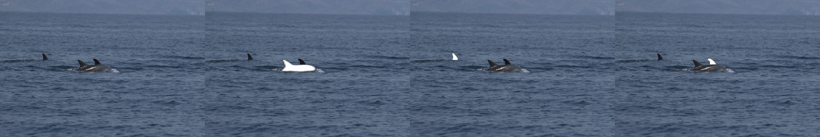

IOU metric: 0.7575817054309009


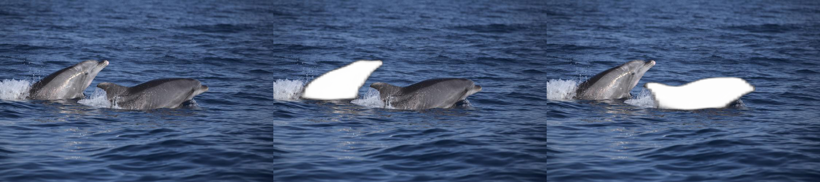

In [ ]:
#slow

show_predictions_sorted_by_iou(model, data_loader_test.dataset)

## Submit solution

Here we can see how to use the `submit_model` function. We must pass trained model, an alias that will be displayed on the leaderboard, name and email. Returns the path to the zipped file. 

In [ ]:
# slow

from dolphins_recognition_challenge.submissions import submit_model

zip_fname = submit_model(model, alias="dolphin123", name="Name Surname", email="name.surname@gmail.com")

Here we can check what is in the zip file. The zip file contains the model and 2 csv files. The first CSV file contains the iou metrics for each image from the validation set, and the second file contains information about the competitor.

In [ ]:
# slow

!unzip -vl "{zip_fname}"

Archive:  submission-iou=0.46613-dolphin123-name.surname@gmail.com-2020-12-22T15:35:04.875962.zip
 Length   Method    Size  Cmpr    Date    Time   CRC-32   Name
--------  ------  ------- ---- ---------- ----- --------  ----
    3355  Stored     3355   0% 2020-12-22 15:35 f521d126  tmp/submission-2020-12-22T15:35:04.875962-m96v0mc3/metrics.csv
176247141  Stored 176247141   0% 2020-12-22 15:35 548de38a  tmp/submission-2020-12-22T15:35:04.875962-m96v0mc3/model.pt
      94  Stored       94   0% 2020-12-22 15:35 cfa87594  tmp/submission-2020-12-22T15:35:04.875962-m96v0mc3/info.csv
--------          -------  ---                            -------
176250590         176250590   0%                            3 files
